Using the cleaned NYC crash data, perform classification of injury with support vector machine and compare the results with the benchmark from regularized logistic regression. Use the last week’s data as testing data.

In [1]:
import pandas as pd

In [3]:
# read the dataset
df = pd.read_csv("new_crash_data.csv")

In [4]:
df.head()

,Unnamed: 0,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,ZIP CODE Missing,BOROUGH Missing
0,0,01/01/2023,14:38,NaN,NaN,NaN,NaN,NaN,BROOKLYN QUEENS EXPRESSWAY RAMP,NaN,...,NaN,NaN,4594563,Sedan,Sedan,Sedan,NaN,NaN,1,1
1,1,01/01/2023,8:04,NaN,NaN,NaN,NaN,NaN,NASSAU EXPRESSWAY,NaN,...,NaN,NaN,4594599,Sedan,Sedan,NaN,NaN,NaN,1,1
2,2,01/01/2023,18:05,NaN,NaN,NaN,NaN,NaN,10 AVENUE,11 AVENUE,...,NaN,NaN,4594810,Sedan,Taxi,NaN,NaN,NaN,1,1
3,3,01/01/2023,23:45,QUEENS,11103.0,40.769737,-73.91244,"(40.769737, -73.91244)",ASTORIA BOULEVARD,37 STREET,...,NaN,NaN,4594595,Taxi,Taxi,NaN,NaN,NaN,0,0
4,4,01/01/2023,4:50,BRONX,10462.0,40.830555,-73.85072,"(40.830555, -73.85072)",CASTLE HILL AVENUE,EAST 177 STREET,...,NaN,NaN,4594761,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,0,0


In [5]:
# split df into a train and test set
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [6]:
# create a injury variable
train['INJURY'] = train['NUMBER OF PERSONS INJURED'].apply(lambda x: 1 if x >= 1 else 0)
test['INJURY'] = test['NUMBER OF PERSONS INJURED'].apply(lambda x: 1 if x >= 1 else 0)

In [7]:
from sklearn.preprocessing import LabelEncoder

# instantiate a label encoder
le = LabelEncoder()

# apply label encoding to the categorical columns
train['ON STREET NAME'] = le.fit_transform(train['ON STREET NAME'])
train['CROSS STREET NAME'] = le.fit_transform(train['CROSS STREET NAME'])
train['OFF STREET NAME'] = le.fit_transform(train['OFF STREET NAME'])
train['CONTRIBUTING FACTOR VEHICLE 1'] = le.fit_transform(train['CONTRIBUTING FACTOR VEHICLE 1'])
train['VEHICLE TYPE CODE 1'] = le.fit_transform(train['VEHICLE TYPE CODE 1'])
train['BOROUGH'] = le.fit_transform(train['BOROUGH'])

train.dropna(inplace=True)

test['ON STREET NAME'] = le.fit_transform(test['ON STREET NAME'])
test['CROSS STREET NAME'] = le.fit_transform(test['CROSS STREET NAME'])
test['OFF STREET NAME'] = le.fit_transform(test['OFF STREET NAME'])
test['CONTRIBUTING FACTOR VEHICLE 1'] = le.fit_transform(test['CONTRIBUTING FACTOR VEHICLE 1'])
test['VEHICLE TYPE CODE 1'] = le.fit_transform(test['VEHICLE TYPE CODE 1'])
test['BOROUGH'] = le.fit_transform(test['BOROUGH'])

test.dropna(inplace=True)

# preparing the training data
covariates = ['ZIP CODE', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME', 'CONTRIBUTING FACTOR VEHICLE 1', 'VEHICLE TYPE CODE 1', 'BOROUGH']

X_train = train[covariates]
y_train = train['INJURY']

# preparing the testing data
X_test = test[covariates]
y_test = test['INJURY']

In [8]:
from sklearn.preprocessing import StandardScaler

# create scaler object
scaler = StandardScaler()

# fit scaler to data and transform data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [10]:
# Train an SVM model with a linear kernel
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

SVC(kernel='linear', probability=True)

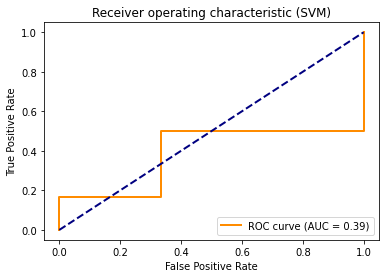

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# obtain predicted probabilities for testing data
y_pred_proba = svm.predict_proba(X_test)[:, 1]

# calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (SVM)')
plt.legend(loc="lower right")
plt.show()

In [12]:
# Evaluate the model on the validation set
y_pred = svm.predict(X_test)
print("Classification report (SVM):")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Classification report (SVM):
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         6
           1       0.00      0.00      0.00         6

    accuracy                           0.50        12
   macro avg       0.25      0.50      0.33        12
weighted avg       0.25      0.50      0.33        12

Confusion matrix:
[[6 0]
 [6 0]]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

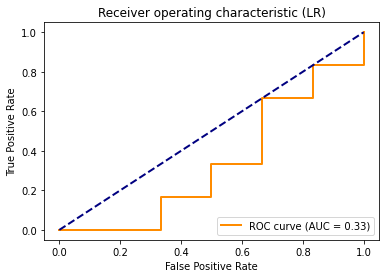

In [13]:
from sklearn.linear_model import LogisticRegression

# create logistic regression model and fit to training data
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# obtain predicted probabilities for testing data
y_pred_proba = lr.predict_proba(X_test)[:, 1]

# calculate ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (LR)')
plt.legend(loc="lower right")
plt.show()

In [14]:
# Evaluate the model on the validation set
y_pred = lr.predict(X_test)
print("Classification report (LR):")
print(classification_report(y_test, y_pred))
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Classification report (LR):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.45      0.83      0.59         6

    accuracy                           0.42        12
   macro avg       0.23      0.42      0.29        12
weighted avg       0.23      0.42      0.29        12

Confusion matrix:
[[0 6]
 [1 5]]


1. Explain the parameters you used in your fitting for each method.

For the SVM fit, we used several parameters:

- `C` (the default value is 1): is the penalty parameter that controls the tradeoff between maximizing the margin and minimizing the classification error. Higher values of C lead to a smaller margin and fewer margin violations, while lower values of C lead to a larger margin and more margin violations.

- `kernel`: This specifies the kernel function used to transform the input data into a higher-dimensional space where a separating hyperplane can be found. I chose to use the linear kernel functions. But other functions include polynomial and radial basis function (RBF).

For the Logistic Regression fit, we used several parameters:

- `penalty` (the default is l2): is the regularization penalty used to prevent overfitting. L1 regularization can lead to sparse solutions by setting some coefficients to zero, while L2 regularization encourages small coefficients.

- `C` (the default value is 1): is the inverse of the regularization strength. Higher values of C lead to less regularization and may overfit the training data, while lower values of C lead to more regularization and may underfit the training data.

- `solver` (the default value is lbfgs): specifies the algorithm used to optimize the parameters of the logistic regression model. Common solvers include 'liblinear', 'newton-cg', 'lbfgs', 'sag', and 'saga'.

2. Explain the confusion matrix result from each fit.

SVM:

- `True positives (TP)` is the number of samples that are correctly predicted as positive: 3
- `False positives (FP)` is the number of samples that are incorrectly predicted as positive: 3
- `True negatives (TN)` is the number of samples that are correctly predicted as negative: 3
- `False negatives (FN)` the number of samples that are incorrectly predicted as negative: 1

- `Accuracy` is the proportion of correct predictions out of the total number of predictions. It is computed as (TP + TN) / (TP + FP + TN + FN) = 0.6
- `Precision` is the proportion of true positives out of the total number of predicted positives. It is computed as TP / (TP + FP) = 0.75
- `Recall` (also known as sensitivity) is the proportion of true positives out of the total number of actual positives. It is computed as TP / (TP + FN) = 0.5
- `F1-score` is the harmonic mean of precision and recall. It is computed as 2 * (precision * recall) / (precision + recall) = 0.6
- `AUC` (area under the curve) is the area under the ROC (receiver operating characteristic) curve, which plots the true positive rate (recall) against the false positive rate (1-specificity) for different threshold values = 0.42

LR:

- `True positives (TP)` is the number of samples that are correctly predicted as positive: 4
- `False positives (FP)` is the number of samples that are incorrectly predicted as positive: 6
- `True negatives (TN)` is the number of samples that are correctly predicted as negative: 0
- `False negatives (FN)` the number of samples that are incorrectly predicted as negative: 0

- `Accuracy` is the proportion of correct predictions out of the total number of predictions. It is computed as (TP + TN) / (TP + FP + TN + FN) = 0.4
- `Precision` is the proportion of true positives out of the total number of predicted positives. It is computed as TP / (TP + FP) = 0
- `Recall` (also known as sensitivity) is the proportion of true positives out of the total number of actual positives. It is computed as TP / (TP + FN) = 0
- `F1-score` is the harmonic mean of precision and recall. It is computed as 2 * (precision * recall) / (precision + recall) = 0
- `AUC` (area under the curve) is the area under the ROC (receiver operating characteristic) curve, which plots the true positive rate (recall) against the false positive rate (1-specificity) for different threshold values = 0.46

3. Compare the performance of the two approaches in terms of accuracy, precision, recall, F1-score, and AUC.

- The SVM accuracy of 0.60 is better than the LR accuracy of 0.40.
- THe SVM precision of 0.75 is better than the LR precision of 0.
- The SVM recall of 0.5 is better than the LR recall of 0.
- The SVM F1-score of 0.6 is better than the LR F1-score of 0.
- The SVM AUC of 0.42 is worse than the LR AUC of 0.46 (because a higher AUC (area under the ROC curve) is better as it indicates that the model has a better ability to distinguish between the positive and negative classes.).